# Market generator

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import datetime

import base
import market_generator
from utils import tosig

In [2]:
# Signature order
order = 4

## Load monthly paths

In [3]:
# ^GSPC is S&P 500.
ticker = "^GSPC"
MG = market_generator.MarketGenerator(ticker, start=datetime.date(2000, 1, 1))

Computing log-signatures: 100%|██████████| 228/228 [00:00<00:00, 5610.85it/s]


## Plot paths

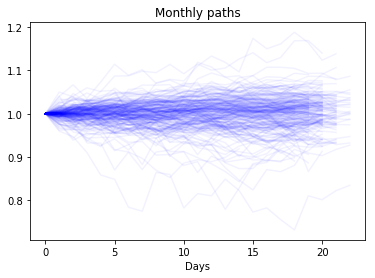

In [4]:
for path in MG.windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.05)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

## Train generative model

In [5]:
MG.train()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Training: 100%|██████████| 10000/10000 [00:09<00:00, 1010.50it/s]


## Generate

In [6]:
generated = np.array([MG.generate(cond) for cond in MG.conditions])
#generated = MG.generate(MG.conditions[150], n_samples=len(MG.logsigs))

generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.orig_logsig)])

100%|██████████| 228/228 [00:03<00:00, 57.79it/s]


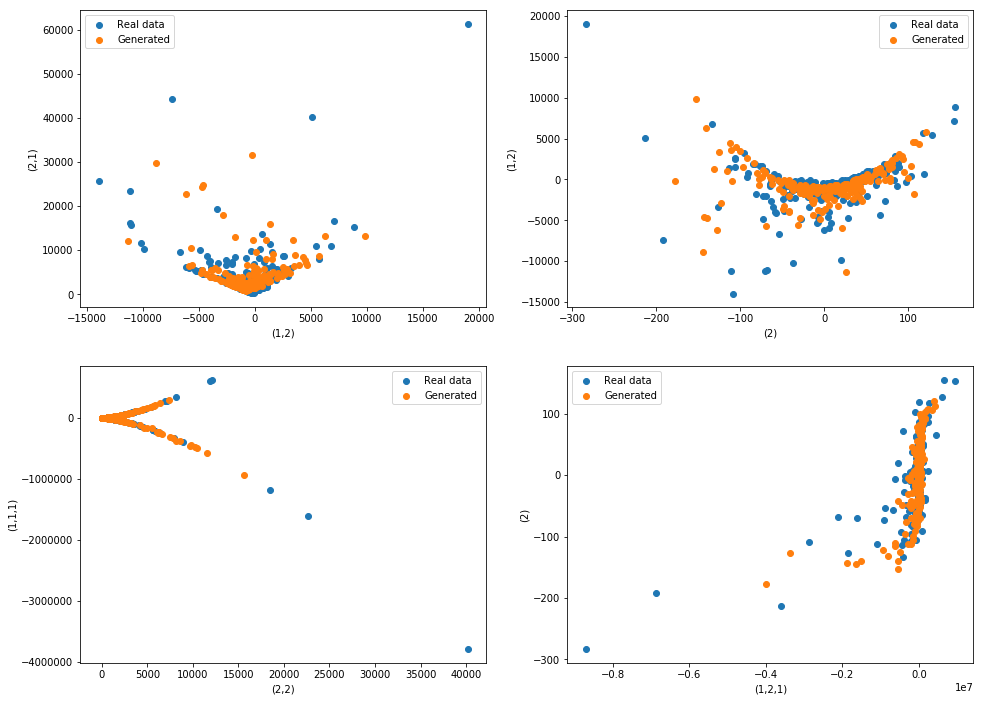

In [7]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

plt.figure(figsize=(16, 12))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(real_sigs[:, projection[0]], real_sigs[:, projection[1]],
                label="Real data")
    plt.scatter(generated_sigs[:, projection[0]], generated_sigs[:, projection[1]],
               label="Generated")
    plt.xlabel(keys[projection[0]])
    plt.ylabel(keys[projection[1]])
    plt.legend()
    
plt.show()

## Validation: two-sample statistical test

In [8]:
import process_discriminator

normalised_generated = np.array([MG.generate(cond, normalised=True) for cond in MG.conditions])
sigs1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(normalised_generated)])
sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.logsigs)])

res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.99)

print("Are the generated and real distributions DIFFERENT? {}".format(res))

Computing signatures of population 2: 100%|██████████| 227/227 [00:00<00:00, 1649.67it/s]


Are the generated and real distributions DIFFERENT? False


## Invert log-signature

In [9]:
import logsig_inversion
from esig.tosig import stream2logsig
from utils.leadlag import leadlag

logsig = MG.generate(MG.conditions[0])

In [10]:
pip = 0.01
n_pips = 50 * 100 # 50$
n_points = 21

n_iterations = 1000
n_organisms = 100

recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

Loss: 0.0059136752980527086: 100%|██████████| 1000/1000 [00:54<00:00, 15.91it/s]


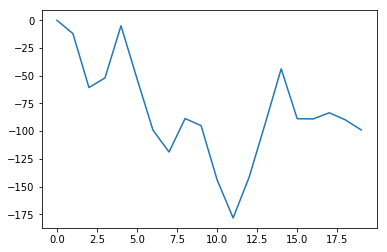

Target log-signature: [-98.97862243652344, -98.66437530517578, -11184.8525390625, 328104.84375, 397436.71875, -12424811.0, -20413564.0, -12800589.0]
Recovered log-signature: [-98.98000000000002, -98.98000000000002, -11226.4997, 333124.88982716645, 361204.4916428333, -12369690.681209806, -22635484.94624328, -12175088.963466063]


In [11]:
plt.plot(recovered_path)
plt.show()
print(f"Target log-signature: {logsig.tolist()}")
print(f"Recovered log-signature: {stream2logsig(leadlag(recovered_path), order).tolist()}")

In [12]:
paths = []
for condition in MG.conditions:
    logsig = MG.generate(condition)
    recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)
    
    paths.append(recovered_path)

Loss: 0.06020565367081985: 100%|██████████| 1000/1000 [00:55<00:00, 17.86it/s]


Loss: 0.024507378483512428: 100%|██████████| 1000/1000 [00:52<00:00, 19.25it/s]


Loss: 0.03377796207018059: 100%|██████████| 1000/1000 [00:51<00:00, 19.11it/s]


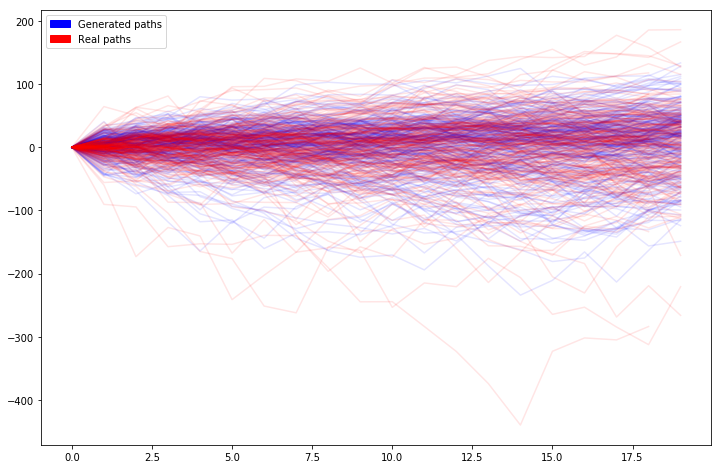

In [27]:
import matplotlib.patches as mpatches

plt.figure(figsize=(12, 8))
for path in paths:
    plt.plot(path, "b", alpha=0.1)
    

for path in MG.windows:
    returns = path[::2, 1][:20] - path[0, 1]
    plt.plot(returns, "r", alpha=0.1)
    
blue_patch = mpatches.Patch(color='blue', label='Generated paths')
red_patch = mpatches.Patch(color='red', label='Real paths')
plt.legend(handles=[blue_patch, red_patch])    
    
plt.show()